# SARIMAX - Seasonal Autoregressive Integrated Moving Average Exogenous

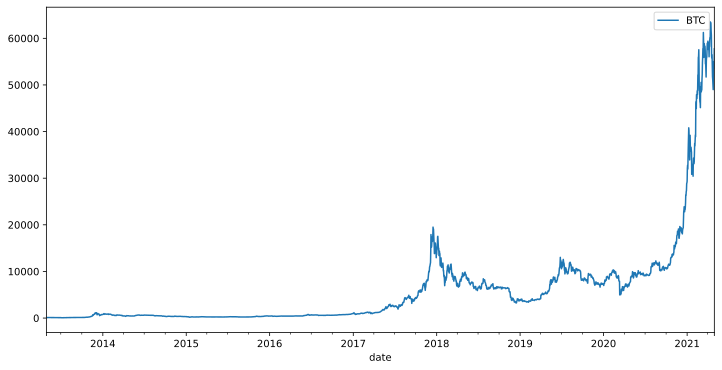

In [1]:
import os
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import set_matplotlib_formats
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
set_matplotlib_formats('svg')

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

folder = f'../02.Prepared_data/2021-05-01/'

def load_coins(folder):
#     folder = f'../02.Prepared_data/2021-04-05/'
    
    BTC = pd.read_csv(f"{folder}/BTC_Bitcoin.csv", index_col=0, parse_dates=['date'])
    ETH = pd.read_csv(f"{folder}/ETH_Ethereum.csv", index_col=0, parse_dates=['date'])
    XMR = pd.read_csv(f"{folder}/XMR_Monero.csv", index_col=0, parse_dates=['date'])
    DASH = pd.read_csv(f"{folder}/DASH_Dash.csv", index_col=0, parse_dates=['date'])
    LTC = pd.read_csv(f"{folder}/LTC_Litecoin.csv", index_col=0, parse_dates=['date'])
    XRP = pd.read_csv(f"{folder}/XRP_XRP.csv", index_col=0, parse_dates=['date'])
    ADA = pd.read_csv(f"{folder}/ADA_Cardano.csv", index_col=0, parse_dates=['date'])
    DOT = pd.read_csv(f"{folder}/DOT_Polkadot.csv", index_col=0, parse_dates=['date'])

    coins = [ETH, XMR, DASH, LTC, XRP, ADA, DOT]
    # make sure that all have date as index
    new_coins = []
    for df in coins:
        df = df.sort_values(by='date')
        df = df.drop_duplicates(subset='date', keep='first')
        df = df.set_index('date', drop=True)
        df = df.asfreq('D', method='ffill')
        new_coins.append(df)

    BTC = BTC.sort_values(by='date')
    BTC = BTC.drop_duplicates(subset='date', keep='first')
    BTC = BTC.set_index('date', drop=True)
    BTC = BTC.asfreq('D', method='ffill')
    coins = [BTC] + new_coins

    cols = ['BTC', 'ETH', 'XMR', 'DASH', 'LTC', 'XRP', 'ADA', 'DOT']
    df = pd.DataFrame()

    for col, coin in zip(cols, coins):
        vals = coin['close'].asfreq('D', method='ffill') # in case there were some skipped days
        df[col] = vals
        
    return df


coins = load_coins(folder)
BTC = pd.DataFrame()
BTC['BTC'] = coins['BTC']

BTC.loc[:].plot(figsize=(12,6))
BTC.head()

path = '../01.Original_data/time_series_course_Data/'
data_passengers = pd.read_csv(f"{path}airline_passengers.csv", parse_dates=True, index_col=0)
data_passengers.index.freq = 'MS'
data_births = pd.read_csv(f"{path}daily_female_births.csv", parse_dates=True, index_col=0)
data_births.index.freq = 'D'

data_samples = pd.read_csv(f"{path}samples.csv", parse_dates=True, index_col=0)
data_samples.index.freq = 'MS'
data_trade = pd.read_csv(f"{path}TradeInventories.csv", parse_dates=True, index_col="Date")
data_trade.index.freq = 'MS'

In [2]:
df_rest = pd.read_csv(f"{path}RestaurantVisitors.csv", parse_dates=True, index_col="date")

In [12]:
df_rest.freq = 'D'
df_rest.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [13]:
df_rest = df_rest.dropna()

In [19]:
# make the restaurant visitor columns integer
cols = df_rest.columns.tolist()
cols = ['rest1',
 'rest2',
 'rest3',
 'rest4',
 'total']

In [20]:
for c in cols:
    df_rest[c] = df_rest[c].astype(int)
df_rest.head()

<ipython-input-20-08c0b18393ec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rest[c] = df_rest[c].astype(int)


,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65,25,67,139,296
2016-01-02,Saturday,0,na,24,39,43,85,191
2016-01-03,Sunday,0,na,24,31,66,81,202
2016-01-04,Monday,0,na,23,18,32,32,105
2016-01-05,Tuesday,0,na,2,15,38,43,98


## SARIMAX with not exogenous variables (SARIMA)

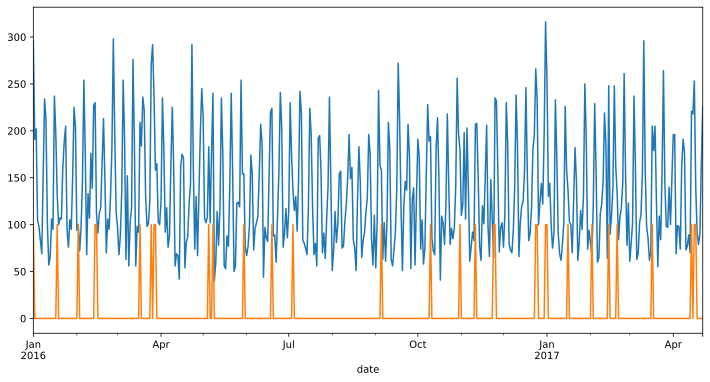

In [21]:
df_rest['total'].plot(figsize=(12,6));
(df_rest['holiday']*100).plot();

Maybe there is seasonality on a weekly level, but on this scale it is not visible.

In [25]:
df_rest.query("holiday==1").index # this is common to use for statsmodels users

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

In [26]:
m = df_rest['holiday'] == 1
df_rest[m].index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

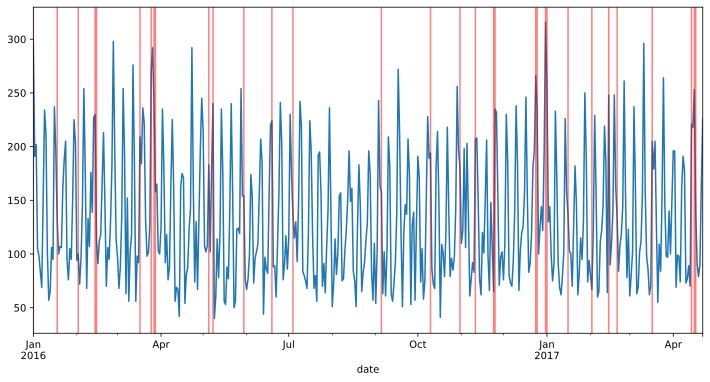

In [31]:
ax = df_rest['total'].plot(figsize=(12,6));
for day in df_rest.query("holiday==1").index:
    ax.axvline(x=day, color='red', alpha=0.5)

Just from visuals, it is not clear if the exogenous variable has an influence or not. Intuitively, this should be obvious though, that restaurants visits and holidays are correlated.

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

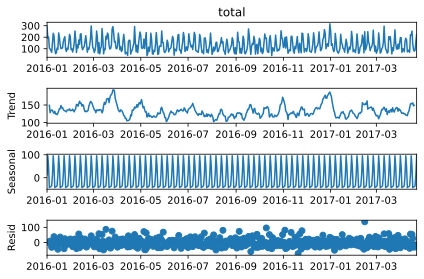

In [33]:
result = seasonal_decompose(df_rest['total'])
result.plot();

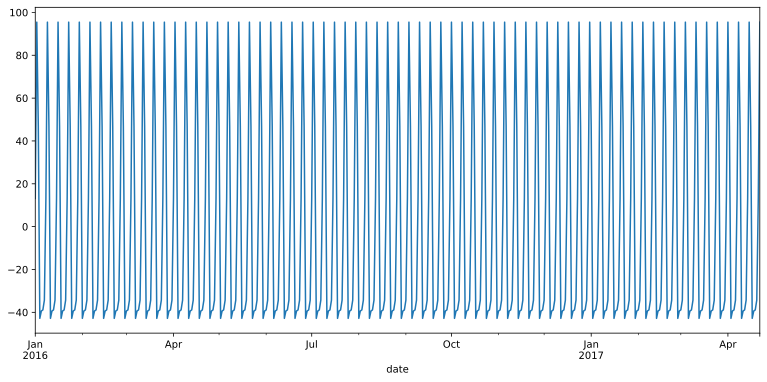

In [34]:
result.seasonal.plot(figsize=(13,6));

There are four seasons per month, so it seems this is a seasonal dataset with seasonality of 4 weeks.

In [35]:
len(df_rest)

478

In [36]:
train = df_rest.iloc[:436] # about one month test set
test = df_rest.iloc[436:]

In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [38]:
auto_arima(df_rest['total'],
           m=7, # daily data so 7 days per week
           seasonal=True
          ).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2383.028
Date:                   Fri, 07 May 2021   AIC                           4774.056
Time:                           08:09:53   BIC                           4790.734
Sample:                                0   HQIC                          4780.613
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.8739      1.483      2.612      0.009       0.967       6.781
ar.S.L7        0.9670      0.012     81.450      0.000       0.944       0.990
ma.S.L7       -0.7578      0.048    -15.784      0.000      -0.852      -0.664
sigma2      1210.2698     71.491     16.929      0.000    1070.150    1350.390
===================================================================================
Ljung-Box (L1) (Q):                  15.44   Jarque-Bera (JB):                68.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                             0.76
Prob(H) (two-sided):                  0.32   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
model = SARIMAX(train['total'], order=(0,0,0), seasonal_order=(1,0,1,7), enforce_invertibility=False)

# courses uses different order
model2 = SARIMAX(train['total'], order=(1,0,0), seasonal_order=(2,0,0,7), enforce_invertibility=False)
 
# enforce intertibility: statsmodels library dependent

/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/hkromer/.pyenv/versions/3.9.0/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [52]:
result = model.fit()
result2 = model2.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2165.369
Date:                   Fri, 07 May 2021   AIC                           4336.738
Time:                           08:15:45   BIC                           4348.970
Sample:                       01-01-2016   HQIC                          4341.565
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9999   9.57e-05   1.04e+04      0.000       1.000       1.000
ma.S.L7       -0.9384      0.024    -39.206      0.000      -0.985      -0.891
sigma2      1111.7903     58.739     18.928      0.000     996.664    1226.916
===================================================================================
Ljung-Box (L1) (Q):                  15.40   Jarque-Bera (JB):                83.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.72
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
start = len(train)
end = len(train) + len(test) - 1
predictions = result.predict(start, end).rename('SARIMAX predictions')
predictions2 = result2.predict(start, end).rename('SARIMAX 2 predictions')

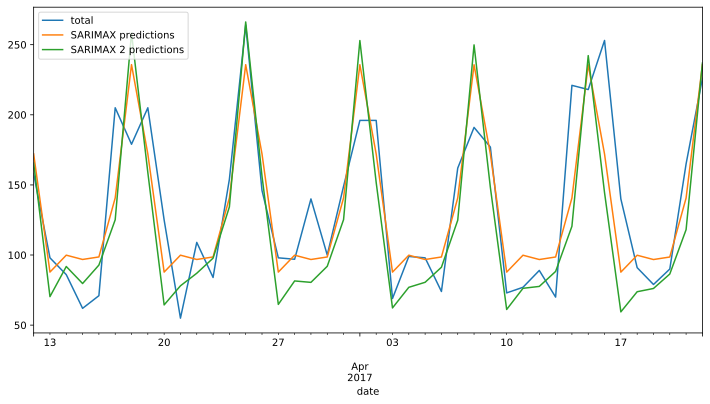

In [56]:
test['total'].plot(figsize=(12,6),legend=True);
predictions.plot(legend=True);
predictions2.plot(legend=True);

Let's check if there is an influence of the holidays.

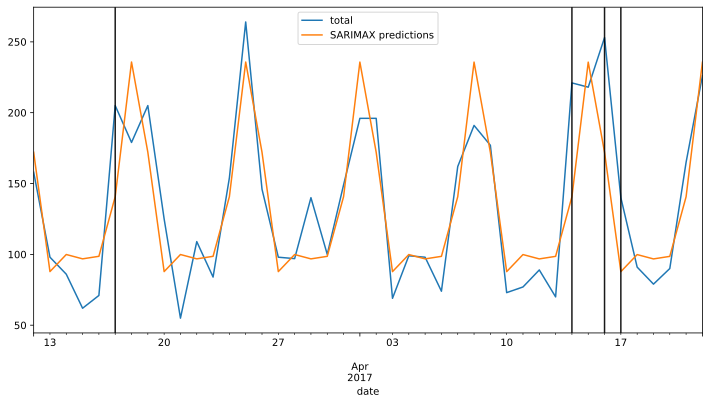

In [59]:
ax = test['total'].plot(figsize=(12,6),legend=True);
predictions.plot(legend=True);
for day in df_rest.query("holiday==1").index:
    ax.axvline(x=day, color='k', alpha=0.9)

In [60]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['total'], predictions)
error

31.912695270772286

RMSE can help us to compare the SARIMA vs the SARIMAX model when we consider holidays in the next part.

## Consider exogenous variables (SARIMAX)